Problem Statement:
Stock-Time-Series-Analysis
Mathematical modeling for financial time series data.
Use LSTMs for predicting the price of stocks of IBM for the year 2017

The data is presented in a couple of formats keeping in mind the computational limitations.
There are files containing 13 years of stock data (in the all_stocks_2006-01-01_to_2018-01-01.csv and corresponding folder) and a smaller version of the dataset (all_stocks_2017-01-01_to_2018-01-01.csv) with only the past year's stock data for those wishing to use something more manageable in size.

The folder individual_stocks_2006-01-01_to_2018-01-01 contains files of data for individual stocks, labelled by their stock ticker name. The all_stocks_2006-01-01_to_2018-01-01.csv and all_stocks_2017-01-01_to_2018-01-01.csv contain this same data, presented in merged .csv files.
Depending on the intended use (graphing, modelling etc.) the user may prefer one of these given formats.

All the files have the following columns: 

* Date - in format: yy-mm-dd
* Open - price of the stock at market open (this is NYSE data so all in USD)
* High - Highest price reached in the day
* Low - Lowest price reached in the day
*  Close - price of the stock at market close
* Volume - Number of shares traded
* Name - the stock's ticker name


In [ ]:
#import libraries

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
#df = pd.read_csv('https://raw.githubusercontent.com/ajain09/Coursera/main/all_stocks_2017-01-01_to_2018-01-01.csv')   #from 2017 to 2018
df = pd.read_csv('https://raw.githubusercontent.com/ajain09/Coursera/main/all_stocks_2006-01-01_to_2018-01-01.csv') #from 2006 to 2018

df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM


In [ ]:
#Deal with column Name

df['Name'].value_counts()

PG       3020
GE       3020
JPM      3020
GS       3020
MMM      3020
NKE      3020
AXP      3020
HD       3020
PFE      3020
UTX      3020
UNH      3020
JNJ      3020
DIS      3020
TRV      3020
KO       3020
IBM      3020
BA       3020
CVX      3020
VZ       3020
MCD      3020
XOM      3020
WMT      3020
CAT      3020
AMZN     3019
AAPL     3019
GOOGL    3019
MSFT     3019
AABA     3019
MRK      3019
INTC     3019
CSCO     3019
Name: Name, dtype: int64

In [ ]:
df = df[df.Name == 'IBM']
df.shape

(3020, 7)

Column Name is not useful for prediction so we will remove it.

In [ ]:
df.drop(columns=['Name'],inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3020 entries, 39258 to 42277
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 165.2+ KB



*   3020 rows 6 columns.
*   Columns Open and Low have one missing value each. Replace it with respective average.
*   Date is in object. Convert it to datetime.




In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

Extract year

In [ ]:
df['Year']=pd.DatetimeIndex(df['Date']).year
df.tail()

,Date,Open,High,Low,Close,Volume,Year
42273,2017-12-22,151.82,153.00,151.50,152.50,2990583,2017
42274,2017-12-26,152.51,153.86,152.50,152.83,2479017,2017
42275,2017-12-27,152.95,153.18,152.61,153.13,2149257,2017
42276,2017-12-28,153.20,154.12,153.20,154.04,2687624,2017
42277,2017-12-29,154.17,154.72,153.42,153.42,3327087,2017


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Year
count,3019.000000,3020.000000,3019.000000,3020.000000,3.020000e+03,3020.000000
mean,145.515545,146.681738,144.471597,145.617278,5.773301e+06,2011.500000
std,37.554946,37.613446,37.477641,37.529387,3.192831e+06,3.451601
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05,2006.000000
25%,116.405000,117.765000,115.490000,116.525000,3.622681e+06,2008.750000
50%,149.610000,150.330000,148.470000,149.315000,4.928852e+06,2011.000000
75%,178.445000,179.762500,177.330000,178.685000,6.965014e+06,2014.250000
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07,2017.000000


Replace null values in columns Open and low with respective averages

In [ ]:
tofill = {'Low':144.47,'Open':145.51}
df.fillna(value = tofill,inplace=True)

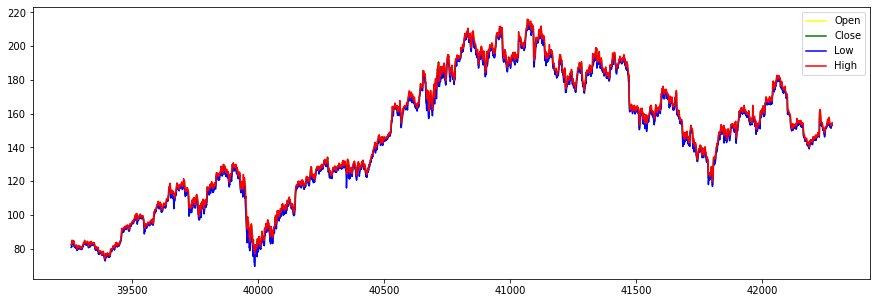

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(df['Open'], color='yellow', label = 'Open')
plt.plot(df['Close'], color='green', label = 'Close')
plt.plot(df['Low'], color='blue', label = 'Low')
plt.plot(df['High'], color='red', label = 'High')
plt.legend()

SPLIT DATA

In [ ]:
to_pred = df.loc[df['Year']==2017].copy()
to_train = df.loc[df['Year']!=2017].copy()

NORMALISE DATA

In [ ]:
X = to_train[['Open', 'Low', 'High', 'Volume']].copy()
y = to_train['Close'].copy()

X_totest = to_pred[['Open', 'Low', 'High', 'Volume']].copy()
y_totest = to_pred['Close'].copy()

In [ ]:
scaler = MinMaxScaler()
X[['Open', 'Low', 'High', 'Volume']] = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1,1))

X_totest[['Open', 'Low', 'High', 'Volume']] = scaler.fit_transform(X_totest)
y_totest = scaler.fit_transform(y_totest.values.reshape(-1,1))

X.shape,y.shape,X_totest.shape,y_totest.shape

((2769, 4), (2769, 1), (251, 4), (251, 1))

CREATING TRAIN TEST DATASET

In [ ]:
n_features = X.shape[1]
window = 22
train_size = 0.9

In [ ]:

def create_data(X, seq_len, train_size=0.9):
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for i in range(len(X_mat) - sequence_length):
        data.append(X_mat[i: i + sequence_length])
    
    data = np.array(data)

    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    return x_train, y_train


In [ ]:
#add column close 
X['Close'] = y
X_totest['Close'] = y_totest

#train test split
X_train, y_train = create_data(X, window)

print (X_train[0], y_train[0])    #print first value

X_test,y_test = create_data(X_totest, window)


np (2471, 22, 5)
[[0.06807347 0.07810773 0.06065089 0.35122061 0.07163682]
 [0.06632081 0.0816989  0.06029868 0.2874084  0.07087325]
 [0.06071228 0.07941989 0.06311637 0.19798075 0.0746911 ]
 [0.07858946 0.09606354 0.0781206  0.23147314 0.0916979 ]
 [0.07964105 0.09585635 0.07262609 0.18588618 0.08322921]
 [0.07298093 0.09406077 0.07171034 0.14649458 0.08558934]
 [0.08153393 0.09599448 0.07657087 0.14906463 0.08628349]
 [0.07767807 0.09599448 0.07058326 0.12013026 0.08211856]
 [0.07192933 0.08977901 0.0669907  0.18804775 0.07934194]
 [0.0705272  0.09005525 0.06494787 0.25068216 0.07816188]
 [0.07893999 0.0968232  0.075796   0.32799141 0.08829654]
 [0.07992148 0.09337017 0.07361229 0.17314825 0.07878662]
 [0.07220976 0.08114641 0.06417301 0.24567141 0.06677773]
 [0.06022154 0.0788674  0.05621302 0.16055669 0.06712481]
 [0.06064218 0.07803867 0.05783319 0.15902146 0.06323754]
 [0.05825855 0.07672652 0.05409975 0.16941401 0.06365403]
 [0.06141335 0.0765884  0.05431107 0.21829268 0.0623351

BUILD MODEL

In [ ]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = build_model(input_shape=(window, 5))

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=300, verbose=0)

Predictions:

In [ ]:
y_pred = model.predict(X_test)
y_pred[:6]

array([[0.8243894 ],
       [0.8494699 ],
       [0.8471469 ],
       [0.9041243 ],
       [0.86475563],
       [0.886044  ]], dtype=float32)

In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_actual = scaler.inverse_transform([y_test])
y_pred[:6]

array([[174.53046],
       [175.5901 ],
       [175.49197],
       [177.89926],
       [176.23593],
       [177.13536]], dtype=float32)

In [ ]:
pred = y_pred.reshape(y_pred.shape[0],1)
actual = y_actual.reshape(y_actual.shape[1],1)

In [ ]:
print(pred[:6])
print(actual[:6])

[[174.53046]
 [175.5901 ]
 [175.49197]
 [177.89926]
 [176.23593]
 [177.13536]]
[[175.82]
 [175.86]
 [178.46]
 [176.17]
 [177.21]
 [178.68]]


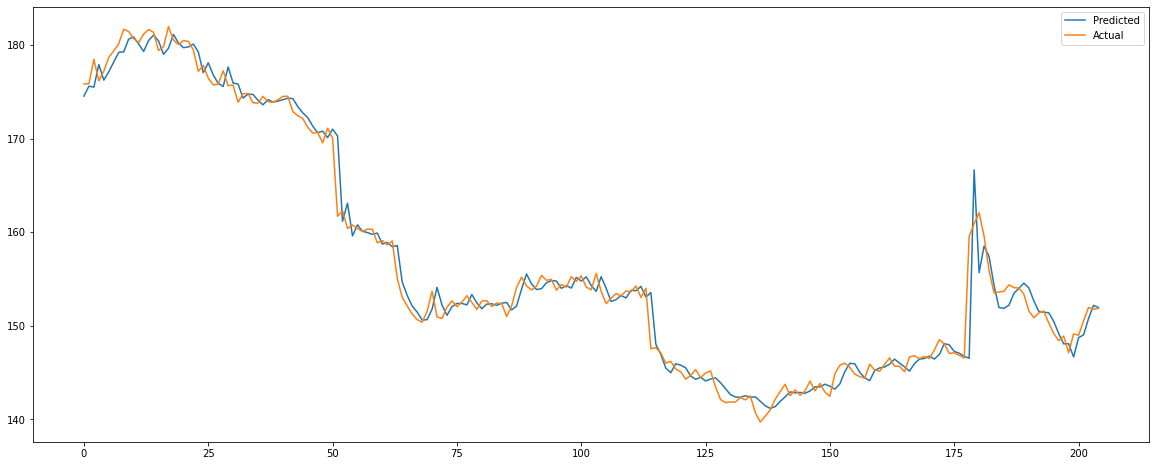

In [ ]:
 plt.figure(figsize=(20,8))

plt.plot(pd.DataFrame(pred), label='Predicted')
plt.plot(pd.DataFrame(actual), label='Actual')
#plt.x
plt.legend(loc='best')
plt.show()